## Results: Learning a new categorization of drugs

Here, we focus on the genes that have been linked to one or more targets. We test for the overlap of the genes associated with each drug to connect drugs. Then we obtain fully connected cliques of drugs.

In [1]:
import sys 
sys.path

sys.path = sys.path[3:] + sys.path[:3]

In [2]:
import networkx
import pickle
import igraph as ig

import numpy as np

import pandas as pd

First gather the drug-gene data, focusing on the genes associated with a drug targets and not widely associated with many drugs.

In [4]:
adj_real = pd.read_csv("results/target_gene_p.adj.txt",sep="\t",index_col=0).fillna(1)

adj_filt = adj_real.loc[:,(adj_real.min(axis=0) < 0.1)]
adj_filt = adj_filt.loc[adj_filt.min(axis=1) < 0.1,:]

drug_gene = pd.read_csv("results/by_adjust.txt.gz",sep="\t",index_col=0)
drug_gene = drug_gene.loc[(drug_gene< 0.05).sum(axis=1)>0,(drug_gene ==0).sum(axis=0)>0]



drug_tsig = drug_gene.loc[:,adj_filt.index] ### alternative...

drug_tsig_narrow = drug_tsig.loc[:,(drug_tsig < 0.05).sum(axis=0) < 20]

cut = 0.05
drug_tsig_narrow = drug_tsig_narrow.loc[(drug_tsig_narrow < 0.01).sum(axis=1) > 0,:]


Test for each pair of drugs if they have more overlapped disease genes than expected at random. To test whether the overlap for a pair of drugs D1 and D2 is more than random, we randomly sampling an equal number of genes for D1 as the true number of genes. The sampling is weighted, so that genes that are associated with more drugs are more likely to be sampled.

In [40]:

drugsdo = drug_tsig_narrow.index
gprob = (drug_gene.loc[:,drug_tsig_narrow.columns] < cut).mean(axis=0)
dd = {}
for d1 in range(len(drugsdo)-1):
    d1d = drugsdo[d1]
    d1gene = drug_tsig_narrow.loc[d1d,:]
    d1gene = set(d1gene[d1gene < cut].index)
    dd[drugsdo[d1]] = {}
    ### sampling the random genes (2000 random samples)
    rands = [np.random.choice(gprob.index,len(d1gene), p=gprob/gprob.sum(), replace=False) for _ in range(2000)]
    for d2 in range(d1+1,len(drugsdo)):
        d2d = drugsdo[d2]
        dgene = drug_tsig_narrow.loc[d2d,:]
        dgene = set(dgene[dgene < cut].index)
        ov = len(d1gene & dgene) #len(d1gene & dgene)
        ### fraction of random overlaps that are at least as big as the true overlap
        dd[d1d][d2d] = [ov, (np.array([len(dgene & set(r)) for r in rands]) >= ov).mean()]


e = {k:{vv:z[0] for vv,z in v.items()} for k, v in dd.items()}

f = {k:{vv:z[1] for vv,z in v.items()} for k, v in dd.items()}

df = pd.DataFrame({'p':pd.DataFrame(f).stack(), 'ct':pd.DataFrame(e).stack()})

df['dd'] = df.reset_index()['level_0'].values + "-" + df.reset_index()['level_1'].values

ovl = []
for (d1d, d2d), v in df.iterrows():
    d1gene = drug_tsig_narrow.loc[d1d,:]
    d1gene = set(d1gene[d1gene < cut].index)
    dgene = drug_tsig_narrow.loc[d2d,:]
    dgene = set(dgene[dgene < cut].index)
    ovl.append(",".join(d1gene & dgene))
df['ov'] = ovl
df2 = df.loc[df['ct'] > 0,:]
df2.sort_values('p')

,,p,ct,dd,ov
Nisoldipine,Nifedipine,0.0,9.0,Nisoldipine-Nifedipine,"RP3-460G2.2,CTD-2623N2.11,LIAS,DALRD3,TSSK4,DA..."
Propafenone,Imipramine,0.0,17.0,Propafenone-Imipramine,"NAXE,PPP3R1,RP5-1085F17.3,DLEU1,RRP8,GPATCH2,P..."
Mepyramine,Diphenhydramine,0.0,2.0,Mepyramine-Diphenhydramine,"STARD4,SMG9"
Fluoxetine,Fluphenazine,0.0,41.0,Fluoxetine-Fluphenazine,"ZNF208,DLEU1,SPDYA,SLC35G6,ZNF419,IL23A,ZEB1,D..."
Promethazine,Cyproheptadine,0.0,14.0,Promethazine-Cyproheptadine,"CARD19,PPP3R1,GINS4,USP53,LINC00216,TMA16,DNAJ..."
...,...,...,...,...,...
Cinacalcet hydrochloride,Bepridil,1.0,4.0,Cinacalcet hydrochloride-Bepridil,"SLC26A1,ZNF835,DNHD1,RNF20"
Nifedipine,Imipramine,1.0,1.0,Nifedipine-Imipramine,KLHL20
Raloxifene,Propafenone,1.0,1.0,Raloxifene-Propafenone,ZNF419
Perphenazine,Loratadine,1.0,3.0,Perphenazine-Loratadine,"SELENBP1,RP11-439M11.1,C11orf54"


In [8]:
def repit(xx):
    xx = xx.str.replace(" hydrochloride","").str.replace(" besylate","").str.replace(" cilexetil","").str.replace(" acetate","")
    xx = xx.str.replace(" etexilate mesylate","").str.replace(", diamminedichloro-","")
    xx[xx=='2-[(2,6-Dichlorophenyl)methylideneamino]guanidine'] = "guanaben"
    #'2-[(2,6-Dichlorophenyl)methylideneamino]guanidine'
    return(xx) #dfkeep[c] = xx



In [14]:
df = df.reset_index().rename(columns={'level_0':'d1','level_1':'d2'})
df['d1'] = repit(df['d1'])
df['d2'] = repit(df['d2'])

df.to_csv("results/drug_connect-overlap.txt",sep="\t")

In [3]:
df = pd.read_csv("drug_connect-overlap.txt",sep="\t",index_col=0)

In [14]:
df.head()

,d1,d2,p,ct,dd,ov
0,Bepridil,gamma-Aminobutyric acid,0.4965,1.0,Bepridil-gamma-Aminobutyric acid,DNHD1
1,Bepridil,Dopamine,0.4935,1.0,Bepridil-Dopamine,DALRD3
2,Bepridil,Pyridoxine,0.7615,1.0,Bepridil-Pyridoxine,RP11-134G8.5
3,Bepridil,Amoxapine,0.9725,1.0,Bepridil-Amoxapine,IFI27L1
4,Buspirone,Bepridil,0.2435,5.0,Buspirone-Bepridil,"TSSK4,VAPB,SELENBP1,CSRNP2,DPCR1"


In [4]:
import networkx
def df2cq(dfsig):

    Gf = networkx.Graph()
    Gf.add_edges_from(dfsig.loc[:,['d1','d2']].values.tolist())

    cq = networkx.find_cliques(Gf)
    cq = [i for i in (cq)]
    print(len(cq))

    cq = [i for i in cq if len(i) > 2]
    print(len(cq))
    return(cq)

In [5]:
cq_05 = df2cq(df.loc[df['p'] < 0.05,:])

78
43


In [9]:
cq_02 = df2cq(df.loc[df['p'] < 0.02,:])

53
24


In [87]:
cq_03 = df2cq(df.loc[df['p'] < 0.03,:])

63
34


In [88]:
cq_03

[['Flurazepam', 'Eletriptan', 'Dimenhydrinate', 'Solifenacin', 'Atomoxetine'],
 ['Platinum', 'Felodipine', 'Ketotifen', 'Dopamine'],
 ['Flutamide', 'Fenofibrate', 'Triclosan'],
 ['Nolvasan', 'Cinacalcet', 'Candesartan'],
 ['Nolvasan', 'Cinacalcet', 'Fluphenazine'],
 ['Fenofibrate', 'Pyridoxine', 'Ibuprofen'],
 ['Desloratadine', 'Perphenazine', 'Clomipramine'],
 ['Desloratadine', 'Perphenazine', 'Fluphenazine'],
 ['Modafinil', 'Phenobarbital', 'Amlodipine'],
 ['Diphenhydramine', 'Mepyramine', 'Iloperidone'],
 ['Pindolol', 'Dyphylline', 'Gabapentin', 'Mecamylamine'],
 ['Celecoxib', 'Thalidomide', 'Acetaminophen'],
 ['Nifedipine', 'Nisoldipine', 'Dicyclomine'],
 ['Bepridil', 'Pimozide', 'Verapamil'],
 ['Bepridil', 'Prazosin', 'Omeprazole'],
 ['Bepridil', 'Dicyclomine', 'Nisoldipine'],
 ['Clomipramine', 'Chlorpromazine', 'Perphenazine', 'Fluoxetine'],
 ['Troglitazone',
  'Erlotinib',
  'Hydrochlorothiazide',
  'Miconazole',
  'Clotrimazole'],
 ['Carbimazole', 'Mirtazapine', 'mitomycin C'],

In [6]:
import json
from itertools import chain
lev32d = json.loads(open("intermediate_files/ATC_lev3_drug.json").read())

d2atc = {d:[k for k,v in lev32d.items() if d in v] 
         for d in set(chain.from_iterable(lev32d.values()))}

Clean up the ATC codes -- remove very general codes and also manually add some that were missing

In [9]:
drops = set(['D06-ANTIBIOTICS AND CHEMOTHERAPEUTICS FOR DERMATOLOGICAL USE',
'R02-THROAT PREPARATIONS','A01-STOMATOLOGICAL PREPARATIONS',
'S01-OPHTHALMOLOGICALS','V03-ALL OTHER THERAPEUTIC PRODUCTS',
'N07-OTHER NERVOUS SYSTEM DRUGS',
'S02-OTOLOGICALS'])
d2atc = {repit(pd.Series([d]))[0]:set(a)-drops if len(set(a) - drops) > 0 else  set(a) for d, a in d2atc.items()}

d2atc['Verapamil']=set(['C08-CALCIUM CHANNEL BLOCKERS'])
d2atc['Duloxetine']=set(['N06-PSYCHOANALEPTICS'])
d2atc['Modafinil']=set(['N06-PSYCHOANALEPTICS'])
d2atc['Phenobarbital']=set(['N03-ANTIEPILEPTICS'])
d2atc['Amlodipine']=set(['C08-CALCIUM CHANNEL BLOCKERS'])
d2atc['Desloratadine']=set(['R06-ANTIHISTAMINES FOR SYSTEMIC USE'])

Converte this into a cleaned up bipartite graph between drugs and disease genes. 
Then convert that into a circle.
Add drug-drug edges

doing  Dicyclomine Nisoldipine Nifedipine
doing  Fenofibrate Triclosan Flutamide
doing  Ketoprofen Bezafibrate Ibuprofen
doing  Pindolol Dyphylline Gabapentin Mecamylamine
doing  Verapamil Pimozide Bepridil


/home/rachel_melamed_uml_edu/.conda/envs/scdel/lib/python3.7/site-packages/ipykernel_launcher.py:158: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.


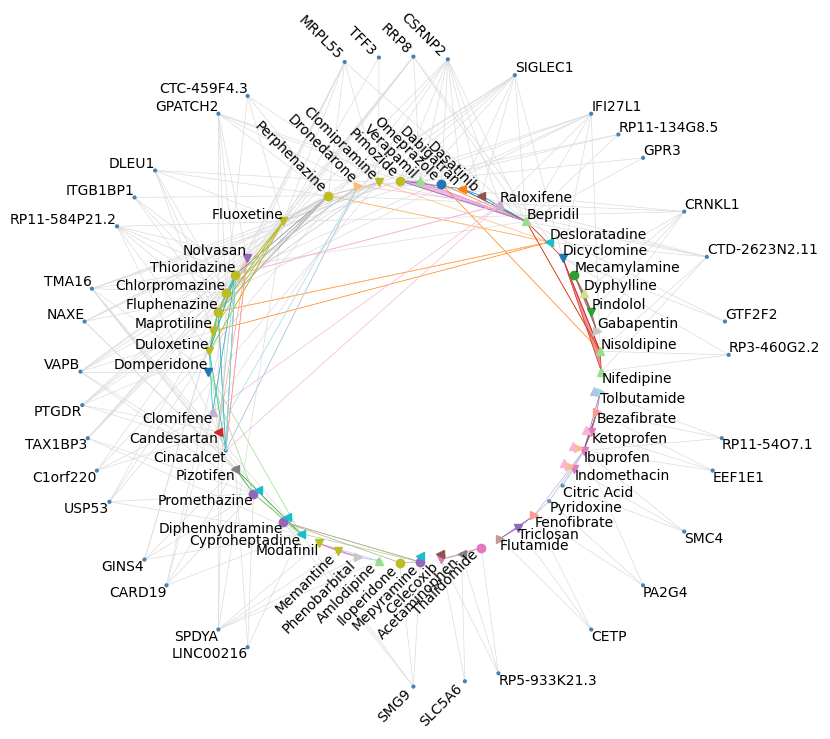

In [12]:

import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

dfsig = df.loc[df['p'] < 0.05,:]
rowkeep = np.zeros(dfsig.shape[0])==1
for i in cq_05:
    rowkeep |= dfsig['d1'].isin(i) & dfsig['d2'].isin(i)


#nk= pd.DataFrame(Counter(chain.from_iterable([ov.split(",") for ov in dfkeep['ov']])),index=['ct']).transpose().sort_values('ct')

dfkeep = dfsig.loc[rowkeep,:].copy()

nk= pd.DataFrame(Counter(chain.from_iterable([ov.split(",") for ov in dfkeep['ov']])),index=['ct']).transpose().sort_values('ct')

from collections import defaultdict
rem = set(nk.loc[nk['ct'] >15].index)
edict = defaultdict(set)
for ix, i in dfkeep.iterrows():
    adds = set(i['ov'].split(",")) - set(rem)
    if not adds:
        continue
    edict[i['d1']] |= adds
    edict[i['d2']] |= adds
edict2 = {}
for e in edict:
    c = [cc for cc in cq_05 if e in cc and len(set(cc) & set(edict.keys())) > 0] 
    if c:
        edict2[e] = edict[e]
edict = edict2
el = []
d = []
g = set([])
for k,v in edict.items():
    el.extend([[k,vi] for vi in v]) #f.write("\n".join([" ".join([k.replace(" ","_"),vi]) for vi in v])+"\n")
    d.append(k)
    g |= v
el = pd.DataFrame(el)

vl = pd.DataFrame({'v':d+ list(g), 'type':['drug']*len(d) + ['gene']*len(g)})

cq = cq_05

gdf = ig.Graph.DataFrame(el, vertices = vl,directed = False)

ll = ig.Graph.layout_bipartite(gdf, np.array(gdf.vs['type']) == 'drug')

ll3 = ig.Layout([[i[1],i[0]] for i in ll.coords])

coo = np.array(ll3.coords)
coo[:5,:]

sel = coo[:,0]==0
theta = coo[sel,1]/(max(coo[:,1]) + 1) * 2 *np.pi
r = 1 + 1, 
x = r * np.cos(theta) 
y = r * np.sin(theta)
#coo[sel
theta_array = np.zeros(len(sel))
theta_array[sel] = theta

rad = np.zeros(coo.shape)
rad[sel,:] = np.array([x,y]).transpose()


sel = coo[:,0]==1
theta = coo[sel,1]/(max(coo[:,1]) + 1) * 2 *np.pi
r = 2.3 + 1, 
x = r * np.cos(theta) 
y = r * np.sin(theta)
#rad = np.zeros(coo.shape)
rad[sel,:] = np.array([x,y]).transpose()
theta_array[sel] = theta

import matplotlib.colors as colors
import matplotlib.cm as cmx
cqkeep = [c for c in cq if len(set(c) - set(edict.keys())) == 0]

jet = plt.get_cmap('tab20')
cNorm = colors.Normalize(vmin=0,vmax=len(cqkeep)) #roths['mapped'].max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
colorVal = scalarMap.to_rgba(1)

dloc = pd.DataFrame(rad, index= gdf.vs['name'], columns=['x','y'])

llrad = ig.Layout(rad[:,:2].tolist())
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9.2,9)) #(9,10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ig.plot(gdf, target=ax, layout = llrad,margin=20,bbox =(300,300), #vertex_label=gdf.vs['label'],
        edge_width=.5, edge_color='gainsboro',vertex_size=2) #label=gdf.vs['label'])
rcut = .8
for ix, i in enumerate(gdf.vs['name']):
    x = rad[ix, 0]
    y = rad[ix, 1]
    rotating = (x <rcut and x > -1*rcut)
    ax.text(x, y, i, rotation = (2*(y>0)-1)*-45 if rotating else 0, ha='right' if (x < 0 or rotating) else 'left',
            va='bottom' if y >0 else 'top')
#Selected a few cliques for visualization
cq_poly = [['Pimozide', 'Verapamil', 'Bepridil'],
   ['Dicyclomine', 'Nifedipine', 'Nisoldipine'],
   ['Ketoprofen', 'Bezafibrate', 'Ibuprofen'],
   ['Flutamide', 'Triclosan', 'Fenofibrate'],
       ['Pindolol', 'Dyphylline', 'Gabapentin', 'Mecamylamine']
      ]
## drug-drug edges
dloc = pd.DataFrame(rad, index= gdf.vs['name'], columns=['x','y'])
theta_array = pd.Series(theta_array, index = gdf.vs['name'])

lineends = []
linecolors = []
for ix, c in enumerate(cqkeep):
    lineends.extend(list(chain.from_iterable([[[dloc.loc[c[d1],:].values.tolist(), dloc.loc[c[d2],:].values.tolist()] for d2 in range(d1+1, len(c))]
                         for d1 in range(len(c)-1)])))
    linecolors.extend([scalarMap.to_rgba(ix)]*int((len(c)*(len(c)-1)/2)))
from matplotlib import collections as mc
lc = mc.LineCollection(lineends,colors=linecolors,linewidths=.5) 

ax.add_collection(lc) 
from matplotlib.patches import Polygon
for ix, c in enumerate(cqkeep):
    if not [j for j in cq_poly if len(set(j) - set(c)) == 0]:
        continue
    color = scalarMap.to_rgba(ix)
    ax.add_patch(
        Polygon(dloc.loc[c,:].values, color=color, alpha=0.5,linestyle='')
    )  
    print('doing ', " ".join(c))
marker = ["o","v","^","<",">"]
atcplot = sorted(set(chain.from_iterable([d2atc[k] for k in dloc.index if k in d2atc])))
cNorm = colors.Normalize(vmin=0,vmax=len(atcplot))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
xv = dloc['x'].max()*1.3
ymax = dloc['y'].max()
inc = (ymax - dloc['y'].min())/len(atcplot)
#ax.set_xlim(-3,4) 
atc2i = {cat:ix for ix, cat in enumerate(atcplot)}
for d in edict: #ix, cat in enumerate(atcplot):
    #drugs = [d for d,v in d2atc.items() if d in edict.keys() and cat in v] #set(lev32d[cat]) & set(edict.keys())
    x = dloc.loc[d,'x']
    y = dloc.loc[d,'y']
    theta = theta_array.loc[d]
    inc = -.05 #*np.sign(x)
    if d not in d2atc:
        continue
    atcs = d2atc[d]
    for ix,i in enumerate(atcs):
        
        xa = (2 - .06*ix) * np.cos(theta) 
        ya = (2 - .06*ix) * np.sin(theta)
        ax.plot(xa, ya, '.',marker=marker[atc2i[i]%len(marker)], color = scalarMap.to_rgba(atc2i[i]), 
               markersize = 6 )#*(.9*(len(atcplot)-ix))# 6

fig.savefig("figs/fig_circle.pdf",bbox_inches='tight')           


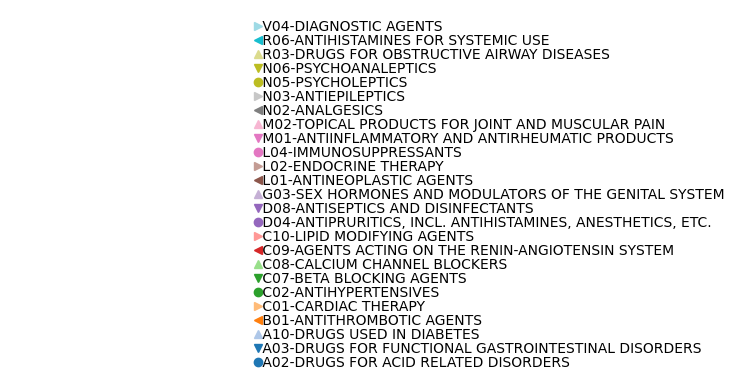

In [13]:
fig, ax = plt.subplots(1) #(9,10))

for ix, cat in enumerate(atcplot):
    
    ax.plot(xv, ymax - inc*ix, color = scalarMap.to_rgba(ix), marker = marker[ix%len(marker)],markersize = 6)
    ax.text(xv, ymax - inc*ix, ' ' + cat, ha='left',va='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("figs/fig_circle_legend.pdf",bbox_inches='tight')   